# Übung 1: Perzeptron

## Aufgabenstellung:

1. Aufgabe: Implementieren Sie ein Perzeptron zur binären Klassifikation mit Python und Numpy. Ihr Code sollte eine Methode "train" haben, die einen Numpy-Array x an Eingabedaten und einen gleich langen Numpy-Array y an Labels bekommt und eine Methode "infer", die einen Numpy-Array x an Eingabedaten bekommt und Labels dazu zurück gibt.

2. Aufgabe: Generieren Sie geeignete synthetische Daten für eine binäre Klassifikation. Dazu dürfen Sie auch Scipy und Scikit-learn verwenden. Ihr Code sollte das in einer Methode "generate" tun.

3. Aufgabe: Evaluieren Sie Ihre Implementierung des Perzeptrons systematisch anhand der synthetischen Daten und einem Train-Test-Split. Dazu dürfen Sie auch Scipy und Scikit-learn verwenden. Ihr Code sollte das bei Aufruf ausführen und mit print den Fehler (Anteil der falsch klassifizierten) ausgeben.

4. Aufgabe: Evaluieren Sie Ihre Implementierung des Perzeptrons anhand des Iris-Flower-Datasets, aus dem Sie nur die Spezies "setosa" und "versicolor" auswählen. Dazu dürfen Sie auch Scipy und Scikit-learn verwenden. Geben Sie mit print den Fehler auf dem gesamten Datensatz nach Training auf dem gesamten Datensatz aus.

Wenn Sie also alle Aufgaben erledigt haben, sollte ihr Programm bei Aufruf 2 Zeilen ausdrucken.

----

Wir werden uns der Aufgabe so annähern, dass wir erstmal etwas ausprobieren und dann schließlich eine Klasse "Perzeptron" deklarieren, die daraufhin evaluiert wird.
Das hier ist keine Musterlösung in dem Sinne, dass die Aufgabenstellung 100%ig so gelöst wurde, wie von Ihnen erwartet. Stattdessen machen wir hier viel, viel mehr als erwartet wurde.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['figure.figsize'] = (4, 4)

# Example data for binary classification:
xs = np.array([[1,0.3], [-1,1.1], [0,-1.1], [0.8, -0.9]])
ys = np.array([  0,      0,       0,          1])

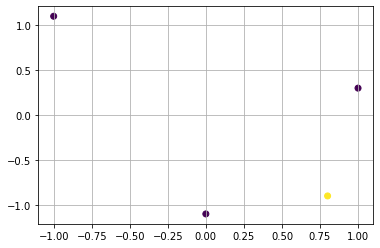

In [3]:
# Let's have a look at the data:
fig, ax = plt.subplots()
ax.grid()
ax.scatter(xs[:,0], xs[:,1], c=ys)
plt.show()

## Funktionale Implementierung

In [4]:
# Perceptron, functional implementation, 1st attempt:

def perceptron_predict(weight_vector, x): # inference
    return 1 if np.dot(weight_vector, x) > 0 else 0

def perceptron_single_update(weight_vector, x, y, learn_rate):
    return weight_vector + learn_rate\
                           * (y - perceptron_predict(weight_vector, x))\
                           * x
    
def perceptron_fit(xs, ys, learn_rate=0.01): # training
    weight_vector = np.ones_like(xs[0], dtype="float64")
    for x, y in zip(xs, ys):
        weight_vector = perceptron_single_update(weight_vector, x, y,
                                                 learn_rate)
    return weight_vector

Wir stellen fest, dass hier über Numpy Arrays iteriert wird - das ist Code, der nicht so leicht in SIMD-Instruktionen umgewandelt werden kann; wir können aber den Compilern helfen, indem wir den Code umschreiben.

Dazu schreiben wir die Methode perceptron_predict so um, dass kein *branching* mehr stattfindet, also keine if-Abfrage:

In [5]:
def perceptron_predict_simd(weight_vector, x):
    return np.where(np.dot(weight_vector, x) > 0, 1, 0)

Diese Methode lässt sich nun auf einen ganzen Array von x'en anwenden, d.h. eine Variable `xs` von `shape` $(n,d)$ wobei $d$ die Dimension von `weight_vector` ist und $n$ die Anzahl Instanzen. Das Skalarprodukt `np.dot` führen wir nur entlang der zweiten Achse aus, sodass das Ergebnis wieder ein Array von `shape` $(n,)$ ist; das geht mit `np.tensordot`.

In [6]:
def perceptron_predict_simd2(weight_vector, xs):
    return np.where(np.tensordot(xs, weight_vector, axes=1) > 0, 1, 0)

# Let's test this:
w = np.array([1,1])
y_pred = perceptron_predict_simd2(w, xs)
print("Anteil falsch klassifiziert: ",
      np.sum(y_pred != ys) / len(ys))

Anteil falsch klassifiziert:  0.75


Allerdings können wir mit diesem Ansatz nicht das Training/Fitten des Perzeptrons vektorisieren (d.h. so umschreiben, dass der Code SIMD-fähig ist, also ohne Branching und ohne Schleifen), denn sobald ein falsch klassifiziertes Sample benutzt wurde um die Gewichte anzupassen, ändert sich das Ergebnis der Vorhersage (somit kommutieren die Operationen nicht, d.h. es ist nicht naiv parallelisierbar).

## Mini-Batch Training

Man kann dennoch einen Trick machen, und "mini-Batches" auf einmal trainieren, und dabei die Gewichtsänderung gleich für mehrere Samples auf einmal durchführen.

In [7]:
def perceptron_fit_simd_minibatch(xs, ys,
                                  learn_rate=0.01, batchsize=1,
                                  weight_vector=np.ones_like(xs[0],
                                                             dtype="float64")
                                 ):
    for batch in range(len(xs)//batchsize):
        xs_batch = xs[batch*batchsize:(batch+1)*batchsize]
        ys_batch = ys[batch*batchsize:(batch+1)*batchsize]
        weight_vector += learn_rate * np.sum( (ys_batch \
                                               - perceptron_predict_simd2(weight_vector,
                                                                          xs_batch))
                                              * xs_batch,
                                             axis=0)
    return weight_vector

# Let's test that with different batchsizes:
for b in [1, 2]:
    w = perceptron_fit_simd_minibatch(xs, ys, batchsize=b)
    print("Gewichtsvektor: ", w)
    y_pred = perceptron_predict_simd2(w, xs)
    print("Anteil falsch klassifiziert: ",
          np.sum(y_pred != ys) / len(ys))

Gewichtsvektor:  [1.008 0.977]
Anteil falsch klassifiziert:  0.75
Gewichtsvektor:  [1.008 0.943]
Anteil falsch klassifiziert:  0.75


Dabei fällt auf, dass immer noch Samples falsch klassifiziert werden. Was passiert, wenn man mit einem besseren Initialgewichtsvektor erneut trainiert?

In [8]:
w = perceptron_fit_simd_minibatch(xs, ys, batchsize=1, weight_vector=w)
print("Gewichtsvektor: ", w)
y_pred = perceptron_predict_simd2(w, xs)
print("Anteil falsch klassifiziert: ",
      np.sum(y_pred != ys) / len(ys))

Gewichtsvektor:  [1.016 0.92 ]
Anteil falsch klassifiziert:  0.5


Wir sehen, dass sich der Gewichtsvektor weiter verändert; die Klassifikation bleibt allerdings, wie sie ist.

In [9]:
iterations = 0
loss = 1
w = np.ones_like(xs[0], dtype="float64")

y_pred = perceptron_predict_simd2(w, xs)
print("actual labels:    ", ys)
print("predicted labels: ", y_pred)

while(loss > 0.1 and iterations < 500):
    w = perceptron_fit_simd_minibatch(xs, ys,
                                      learn_rate=0.01,
                                      batchsize=1,
                                      weight_vector=w)
    y_pred = perceptron_predict_simd2(w, xs)
    loss = np.sum(y_pred != ys) / len(ys)
    if(iterations % 50 == 0): # only every 50th iteration:
        print(iterations, "Gewichtsvektor: ", w)
        print("Anteil falsch klassifiziert: ", loss)
    iterations += 1
    
print("actual labels:    ", ys)
print("predicted labels: ", y_pred)

actual labels:     [0 0 0 1]
predicted labels:  [1 1 0 0]
0 Gewichtsvektor:  [1.008 0.977]
Anteil falsch klassifiziert:  0.75
50 Gewichtsvektor:  [0.698 0.614]
Anteil falsch klassifiziert:  0.25
100 Gewichtsvektor:  [0.342 0.302]
Anteil falsch klassifiziert:  0.25
150 Gewichtsvektor:  [ 8.00000000e-03 -7.91033905e-16]
Anteil falsch klassifiziert:  0.5
200 Gewichtsvektor:  [ 0.008 -0.004]
Anteil falsch klassifiziert:  0.5
250 Gewichtsvektor:  [ 0.006 -0.006]
Anteil falsch klassifiziert:  0.5
300 Gewichtsvektor:  [ 0.004 -0.008]
Anteil falsch klassifiziert:  0.5
350 Gewichtsvektor:  [ 0.002 -0.01 ]
Anteil falsch klassifiziert:  0.25
400 Gewichtsvektor:  [ 2.00000000e-03 -8.46545056e-16]
Anteil falsch klassifiziert:  0.5
450 Gewichtsvektor:  [ 0.004 -0.006]
Anteil falsch klassifiziert:  0.5
actual labels:     [0 0 0 1]
predicted labels:  [1 0 1 1]


Wir sehen also, dass sich die Klassifikation ändert - aber der Gewichtsvektor immer kleiner wird. Das Problem können wir durch Normalisieren lösen, denn uns interessiert ja stets nur das Vorzeichen vom Skalarprodukt mit dem Gewichtsvektor, nie die konkrete Länge.

In [10]:
iterations = 0
loss = 1
w = np.ones_like(xs[0], dtype="float64")

while(loss > 0.1 and iterations < 1000):
    w = perceptron_fit_simd_minibatch(xs, ys,
                                      learn_rate=0.01,
                                      batchsize=1,
                                      weight_vector=w)
    w = w/np.linalg.norm(w) # this is new! <-----------------------
    y_pred = perceptron_predict_simd2(w, xs)
    loss = np.sum(y_pred != ys) / len(ys)
    if(iterations % 200 == 0): # only every Nth iteration:
        print(iterations, "Gewichtsvektor: ", w)
        print("Anteil falsch klassifiziert: ", loss)
    iterations += 1

0 Gewichtsvektor:  [0.7180622  0.69597894]
Anteil falsch klassifiziert:  0.75
200 Gewichtsvektor:  [0.75307154 0.65793864]
Anteil falsch klassifiziert:  0.25
400 Gewichtsvektor:  [0.75191088 0.65926477]
Anteil falsch klassifiziert:  0.25
600 Gewichtsvektor:  [0.75071479 0.66062645]
Anteil falsch klassifiziert:  0.25
800 Gewichtsvektor:  [0.74966481 0.6618177 ]
Anteil falsch klassifiziert:  0.25


Hier sehen wir, dass sich der Gewichtsvektor stabilisiert, also nicht mehr stark ändert. Es scheint, als würde die Perzeptron-Update-Regel keine bessere Klassifikation ermöglichen.

## Training mit Bias-Term

Wir haben eine Optimierung noch nicht genutzt: einen Bias-Term. Wir setzen das um, indem wir nicht das Perzeptron ändern, sondern die Eingabedaten geeignet transformieren.

In [11]:
def transform_to_affine(xs):
    return np.append(np.ones_like(xs[:,0]).reshape(-1,1), xs, axis=1)

print(transform_to_affine(xs))

[[ 1.   1.   0.3]
 [ 1.  -1.   1.1]
 [ 1.   0.  -1.1]
 [ 1.   0.8 -0.9]]


In [12]:
xs_aff = transform_to_affine(xs)
iterations = 0
loss = 1
w = np.ones_like(xs_aff[0], dtype="float64")

while(loss > 0.1 and iterations < 500):
    w = perceptron_fit_simd_minibatch(xs_aff, ys,
                                      learn_rate=0.01,
                                      batchsize=1,
                                      weight_vector=w)
    w = w/np.linalg.norm(w)
    y_pred = perceptron_predict_simd2(w, xs_aff)
    loss = np.sum(y_pred != ys) / len(ys)
    iterations += 1

print("final loss after %s iterations: %s" % (iterations, loss))
print("actual labels:    ", ys)
print("predicted labels: ", y_pred)
print("weight vector:    ", w)

final loss after 182 iterations: 0.0
actual labels:     [0 0 0 1]
predicted labels:  [0 0 0 1]
weight vector:     [-0.68099972  0.7191294  -0.13817487]


Das hat also ganz wunderbar funktioniert. Wir wollen das Ergebnis vielleicht auch noch darstellen.

## Visualisierung der Entscheidungsgrenze

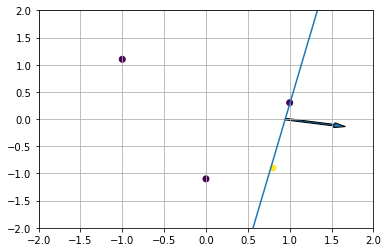

In [13]:
fig, ax = plt.subplots()
ax.grid()
ax.set(xlim = (-2, 2), ylim = (-2, 2))
ax.scatter(xs[:,0], xs[:,1], c=ys)

# compute decision boundary line:
bias, weight = -w[0], w[1:]
slope = - weight[0]/weight[1]
intercept = bias / weight[1]

ax.plot(boundary_x := np.linspace(0, 2, 2), slope * boundary_x + intercept)
ax.arrow(bias/weight[0], 0, weight[0], weight[1],
             width=.03, length_includes_head=True)

plt.show()

Die Richtung, in die der Pfeil zeigt, ist die Seite der Entscheidungsgrenze für die eine Klasse; auf der anderen Seite der Entscheidungsgrenze liegt die andere Klasse.

Im Folgenden können wir nun deutlich erkennen, dass die Entscheidungsgrenze nicht durch den Ursprung geht und stattdessen um den Bias entlang des Gewichtsvektors verschoben ist (und wir sehen, dass der Gewichtsvektor orthogonal auf der Entscheidungsgrenze steht).

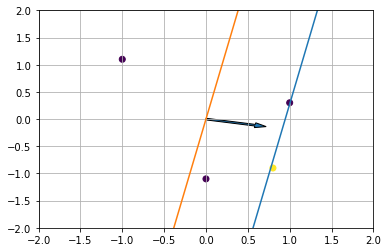

In [14]:
fig, ax = plt.subplots()
ax.grid()
ax.set(xlim = (-2, 2), ylim = (-2, 2))
ax.scatter(xs[:,0], xs[:,1], c=ys)
ax.arrow(0, 0, weight[0], weight[1],
             width=.03, length_includes_head=True)
ax.plot(boundary_x := np.linspace(-1, 2, 2), slope * boundary_x + intercept)
ax.plot(boundary_x := np.linspace(-1, 2, 2), slope * boundary_x)

plt.show()

Wie zuvor besprochen implementieren wir jetzt das Perceptron als eine Klasse (ohne den Minibatch-Schnickschnack), ähnlich wie bei Scikit-learn:

## Objektorientierte Implementierung

In [15]:
class Perceptron:    
    
    def loss(ys_true, ys_pred):
        assert np.shape(ys_true) == np.shape(ys_pred)
        return np.sum(ys_pred != ys_true) / len(ys_true)
    
    def transform_to_affine(xs):
        return np.append(np.ones_like(xs[:,0]).reshape(-1,1), xs, axis=1)
    
    def __init__(self, weight_vector=None, learn_rate=0.01):
        self.weight_vector = weight_vector
        self.learn_rate = learn_rate
    
    def assume_fitted(self):
        if(self.weight_vector is None):
            raise RuntimeError("tried to predict without fit")
        
    def predict(self, xs): # aka infer
        self.assume_fitted()
        if(self.with_bias):
            xs = Perceptron.transform_to_affine(xs)
        return self._predict(xs)
    
    def _predict(self, xs):
        return np.where(np.tensordot(xs, self.weight_vector, axes=1) > 0, 1, 0)

    def _single_update(self, x, y):
        self.weight_vector += self.learn_rate * (y - self._predict(x)) * x
        self.weight_vector /= np.linalg.norm(self.weight_vector[1:])
    
    def fit(self, xs, ys, epochs=1, with_bias=True): # aka train
        # assume number of labels is number of training instances
        assert np.shape(xs)[0] == np.shape(ys)[0]
        
        if(with_bias):
            self.with_bias = True
            xs = Perceptron.transform_to_affine(xs)
        else:
            self.with_bias = False
        
        # initialize with (1,...,1):
        if(self.weight_vector is None):
            self.weight_vector = np.ones_like(xs[0])
        
        # train for some epochs:
        previous_loss = l = 1
        for _ in range(epochs):
            for x, y in zip(xs, ys):
                self._single_update(x, y)
            previous_loss = l
            l = Perceptron.loss(ys, self._predict(xs))

    def get_decision_boundary(self):
        self.assume_fitted()
        if(self.with_bias):
            bias, weight = - self.weight_vector[0], self.weight_vector[1:]
            slope = - weight[0] / weight[1]
            intercept = bias / weight[1]
        else:
            slope = - self.weight_vector[0] / self.weight_vector[1]
            intercept = 0
        return slope, intercept

current loss: 0.0


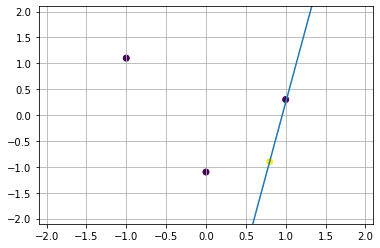

In [16]:
def plot_prediction_with_boundary(xs, ys, epochs=200, with_bias=True):
    P = Perceptron()
    P.fit(xs, ys, epochs=epochs, with_bias=with_bias)
    slope, intercept = P.get_decision_boundary()
    print("current loss:", Perceptron.loss(ys, P.predict(xs)))
    
    #compute ideal square plotting area:
    xmin, xmax = np.min(xs[:,0]), np.max(xs[:,0])
    ymin, ymax = np.min(xs[:,1]), np.max(xs[:,1])
    smallest = np.min([xmin, ymin]) - 1
    biggest = np.max([np.abs(xmax-xmin), np.abs(ymax-ymin)]) + 2
    xlim = (smallest, smallest + biggest)
    ylim = (smallest, smallest + biggest)
    
    fig, ax = plt.subplots()
    ax.grid()
    ax.set(xlim = xlim, ylim = ylim)
    ax.scatter(xs[:,0], xs[:,1], c=ys)
    ax.plot(boundary_x := np.linspace(smallest, biggest, 2),
            slope * boundary_x + intercept)
    plt.show()

# once with the old data:
xs = np.array([[1,0.3], [-1,1.1], [0,-1.1], [0.8, -0.9]])
ys = np.array([  0,        0,       0,          1])
plot_prediction_with_boundary(xs, ys)

## Evaluation mit generierten Daten:

current loss: 0.5


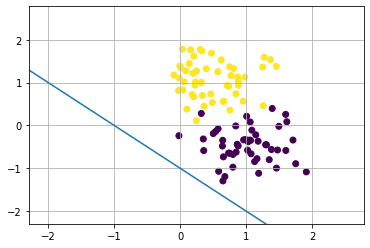

current loss: 0.32


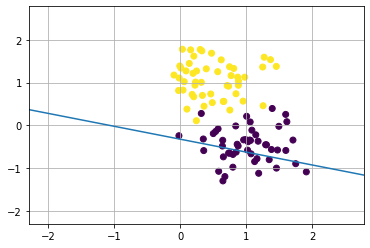

current loss: 0.13


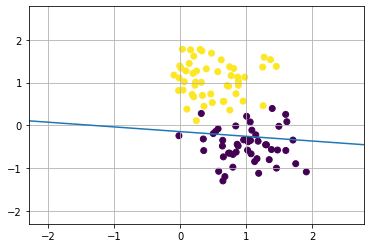

current loss: 0.08


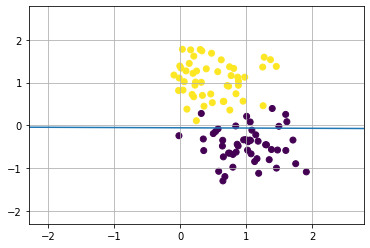

current loss: 0.05


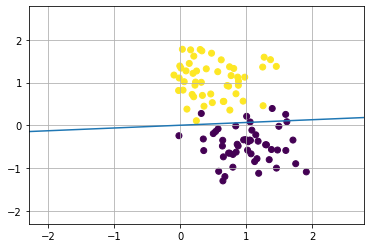

In [17]:
# now with some more interesting data:
from sklearn.datasets import make_blobs

def generate():
    return make_blobs(100, 2, centers=[[1,-.5],[.5,1]],
                      cluster_std=0.4, random_state=0)

xs, ys = generate()

for e in range(5):
    plot_prediction_with_boundary(xs, ys, epochs=e)

## Evaluation auf dem Iris-Datensatz

Hier müssen wir etwas aufpassen: da es 4 Features gibt, können wir nicht davon ausgehen, dass die Entscheidungsgrenze eine Gerade ist. Stattdessen ist die Entscheidungsgrenze eine Hyperebene, die orthogonal auf dem Gewichtsvektor steht. Anstelle des Versuchs, dies in 4D zu visualisieren, transformieren wir die Iris-Daten in Hauptkomponenten und arbeiten mit den ersten beiden Hauptkomponenten.

current loss: 0.01


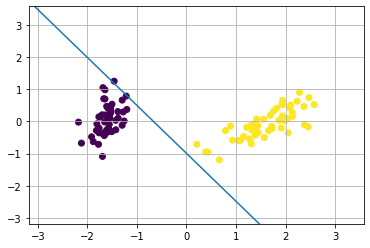

In [18]:
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA

xs, ys = load_iris(return_X_y=True)
xs, ys = xs[ys != 2], ys[ys != 2]
xs = PCA(2).fit_transform(xs)

plot_prediction_with_boundary(xs, ys, epochs=4)